In [1]:
import json
import numpy as np
import pandas as pd

from sncosmo.bandpasses import _BANDPASSES
from astropy.time import Time
import glob

import matplotlib.pyplot as plt
import seaborn as sns


def loadEvent(filename):
    """
    Reads in lightcurve data from a file and returns data in a dictionary format.
    
    Args:
    - filename (str): Path to lightcurve file
    
    Returns:
    - data (dict): Dictionary containing the lightcurve data from the file. The keys are generally 't' and each of the filters in the file as well as their accompanying error values.
    """
    if filename.endswith(".json"):
        with open(filename) as f:
            data = json.load(f)
            for key in data.keys():
                data[key] = np.array(data[key])
    else:
        lines = [line.rstrip("\n") for line in open(filename)]
        lines = filter(None, lines)

        sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
        sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}

        data = {}
        for line in lines:
            lineSplit = line.split(" ")
            lineSplit = list(filter(None, lineSplit))
            mjd = Time(lineSplit[0], format="isot").mjd
            filt = lineSplit[1]

            if filt in sncosmo_maps:
                filt = sncosmo_maps[filt]

            mag = float(lineSplit[2])
            dmag = float(lineSplit[3])

            if filt not in data:
                data[filt] = np.empty((0, 3), float)
            data[filt] = np.append(data[filt], np.array([[mjd, mag, dmag]]), axis=0)

    return data

def read_lightcurve_file(filename: str):
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """
    with open(filename, "r") as f:
        header = list(filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")

bulla_grid_files = sorted(glob.glob("lcs_bulla_2019/lcs/*.dat"))

display(read_lightcurve_file(bulla_grid_files[0]).describe())
bulla_grid_files[0]

,t,ztfg,ztfr,ztfi
count,30.000000,30.000000,30.000000,30.000000
mean,7.750000,-4.172967,-7.176467,-8.710133
std,4.401704,5.305478,4.017439,3.342640
min,0.500000,-14.803000,-15.659000,-15.706000
25%,4.125000,-8.101500,-10.130500,-11.171750
50%,7.750000,-3.494500,-6.550000,-8.216500
75%,11.375000,-0.205250,-3.813750,-5.897500
max,15.000000,5.066000,-1.549000,-3.988000


'lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0.dat'

In [2]:
bulla_grid_lightcurves = {filename: read_lightcurve_file(filename) for filename in list(bulla_grid_files)}

In [68]:
bulla_grid_lightcurves['lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0.dat']

,t,ztfg,ztfr,ztfi
0,0.5,-14.803,-15.659,-15.706
1,1.0,-13.030,-14.177,-14.614
2,1.5,-12.212,-13.340,-13.856
3,2.0,-11.445,-12.683,-13.234
4,2.5,-10.663,-12.081,-12.714
5,3.0,-9.854,-11.478,-12.242
6,3.5,-9.044,-10.872,-11.768
7,4.0,-8.290,-10.271,-11.287
8,4.5,-7.536,-9.709,-10.826
9,5.0,-6.781,-9.139,-10.383


In [3]:
bulla_grid_lightcurves_copy = bulla_grid_lightcurves

# bulla_grid_params = 

print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0])
print('')
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][0:3])
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][3:10])
print('')
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][11:14])
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][14:18])
print('')
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][19:22])
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][22:24])
print('')
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][25:26])
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][26:33])
print('')
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][34:39])
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][39:].split('_')[0])
print('')
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][39:].split('_')[1][0:4])
print(bulla_grid_files[1000].split('/')[-1].split('.dat')[0][39:].split('_')[1][4:])

nph1.0e+06_mej0.05_phi45_T7.0e+03_theta90.00_dMpc0

nph
1.0e+06

mej
0.05

phi
45

T
7.0e+03

theta
90.00

dMpc
0


In [64]:
def extract_params(filename):
    '''
    Extracts the parameter values from the standardized file name format
    '''
    pdict = {}
    pdict['obj_id'] = filename
    fparams = filename.split('/')[-1].split('.dat')[0]
    ## number of Monte Carlo packets
    pdict[fparams[0:3]] = [float(fparams[3:10])]
    ## total ejecta mass
    pdict[fparams[11:14]] = [float(fparams[14:18])]
    ## half-opening angle of the lanthanide-rich component
    pdict[fparams[19:22]] = [float(fparams[22:24])]
    ## temperature at 1 day (T0)
    pdict[fparams[25:26]] = [float(fparams[26:33])]
    ## theta
    pdict[fparams[34:39]] = [float(fparams[39:].split('_')[0])]
    ## dMpc
    pdict[fparams[39:].split('_')[1][0:4]] = [float(fparams[39:].split('_')[1][4:])]
    
    
    return(pd.DataFrame.from_dict(pdict))

extract_params(bulla_grid_files[0])

,obj_id,nph,mej,phi,T,theta,dMpc
0,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...,1000000.0,0.01,15.0,3000.0,0.0,0.0


In [75]:
try:
    df_comb = pd.read_csv('lcs_bulla_2019/combined.csv')
except:
    def combine_lightcurves(lc_dict):
        params_ = ['obj_id', 'nph', 'mej', 'phi', 'T', 'theta', 'dMpc']
        df_list = []
        for key, lc_ in lc_dict.items():
            lc_params = extract_params(key)
            for col_ in params_:
                lc_[col_] = lc_params[col_].tolist()[0]
            df_list.append(lc_)
        
        combined_df = pd.concat(df_list)
        
        return(combined_df)
        

    df_comb = combine_lightcurves(bulla_grid_lightcurves)
    df_comb.to_csv('lcs_bulla_2019/combined.csv')
    
df_comb

,Unnamed: 0,t,ztfg,ztfr,ztfi,obj_id,nph,mej,phi,T,theta,dMpc
0,0,0.5,-14.803,-15.659,-15.706,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...,1000000.0,0.01,15.0,3000.0,0.0,0.0
1,1,1.0,-13.030,-14.177,-14.614,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...,1000000.0,0.01,15.0,3000.0,0.0,0.0
2,2,1.5,-12.212,-13.340,-13.856,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...,1000000.0,0.01,15.0,3000.0,0.0,0.0
3,3,2.0,-11.445,-12.683,-13.234,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...,1000000.0,0.01,15.0,3000.0,0.0,0.0
4,4,2.5,-10.663,-12.081,-12.714,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...,1000000.0,0.01,15.0,3000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
65995,25,13.0,-10.763,-12.258,-13.019,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...,1000000.0,0.10,75.0,9000.0,90.0,0.0
65996,26,13.5,-10.638,-12.149,-12.930,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...,1000000.0,0.10,75.0,9000.0,90.0,0.0
65997,27,14.0,-10.474,-12.035,-12.837,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...,1000000.0,0.10,75.0,9000.0,90.0,0.0
65998,28,14.5,-10.303,-11.917,-12.729,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...,1000000.0,0.10,75.0,9000.0,90.0,0.0


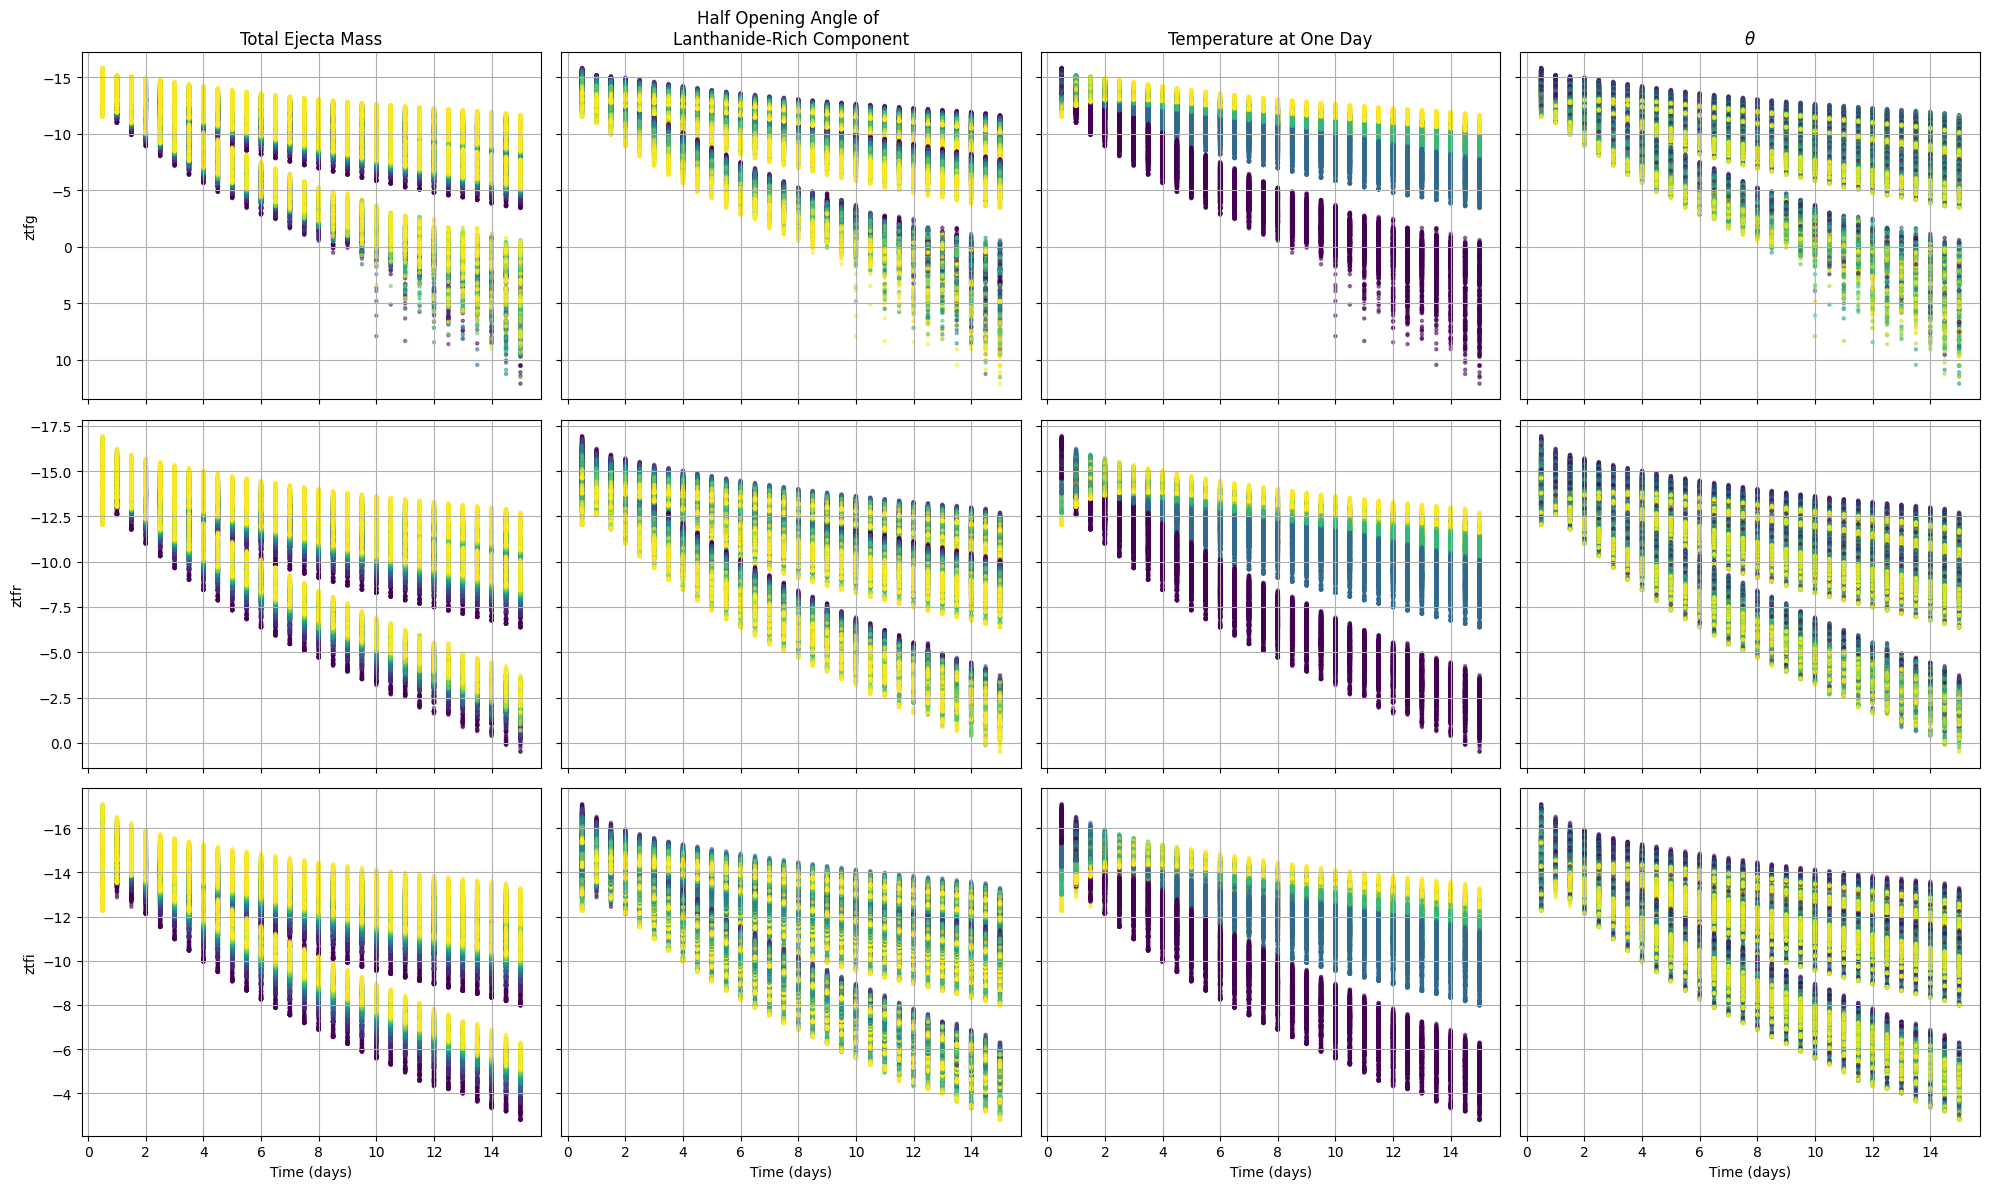

In [ ]:
filters = ['ztfg', 'ztfr', 'ztfi']
params = ['mej', 'phi', 'T', 'theta']
param_labels = {'mej':'Total Ejecta Mass', 'phi':"Half Opening Angle of \nLanthanide-Rich Component", 'T':'Temperature at One Day', 'theta':r'$\theta$'}
fig, axes = plt.subplots(len(filters), len(params), figsize=(20, 12), sharex=True, sharey='row')
axes[0,0].invert_yaxis(), axes[1,0].invert_yaxis(), axes[2,0].invert_yaxis()


for row, filt in enumerate(filters):
    for col, param in enumerate(params):
        sc = axes[row, col].scatter(
            df_comb['t'], df_comb[filt], c=df_comb[param], cmap='viridis', s=5, alpha=0.5
        )
        #axes[row, col].invert_yaxis()
        axes[row,col].grid()
        if row == len(filters) - 1:
            axes[row, col].set_xlabel('Time (days)')
        if col == 0:
            axes[row, col].set_ylabel(filt)
        if row == 0:
            axes[row, col].set_title(param_labels[param])
        # plt.colorbar(sc, ax=axes[row, col], label=param_labels[param], pad=0.01, aspect=20)

plt.tight_layout()
# plt.savefig('figures/grid_by_parameter.pdf')
plt.show()

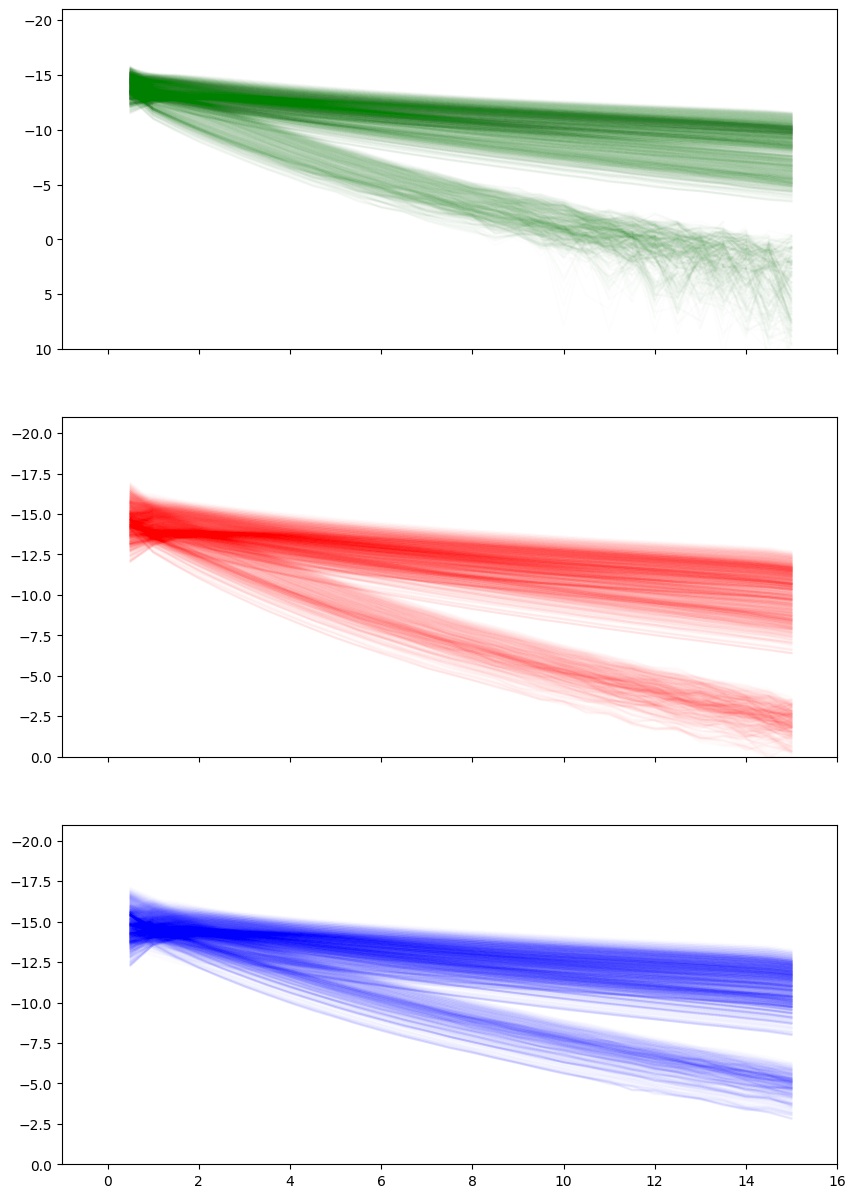

In [3]:
## plot all of the lightcurves in a 3x1 grid where each subplot corresponds to ztfg, ztfr, and ztfi filters
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
[ax[0].plot(value["t"], value["ztfg"], alpha=0.01, color='g') for key, value in bulla_grid_lightcurves.items()]
[ax[1].plot(value["t"], value["ztfr"], alpha=0.01, color='r') for key, value in bulla_grid_lightcurves.items()]
[ax[2].plot(value["t"], value["ztfi"], alpha=0.01, color='b') for key, value in bulla_grid_lightcurves.items()]
ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
[ax[i].set_xlim(-1,16) for i in range(3)];
ax[0].set_ylim(10,-21), ax[1].set_ylim(0,-21), ax[2].set_ylim(0,-21);

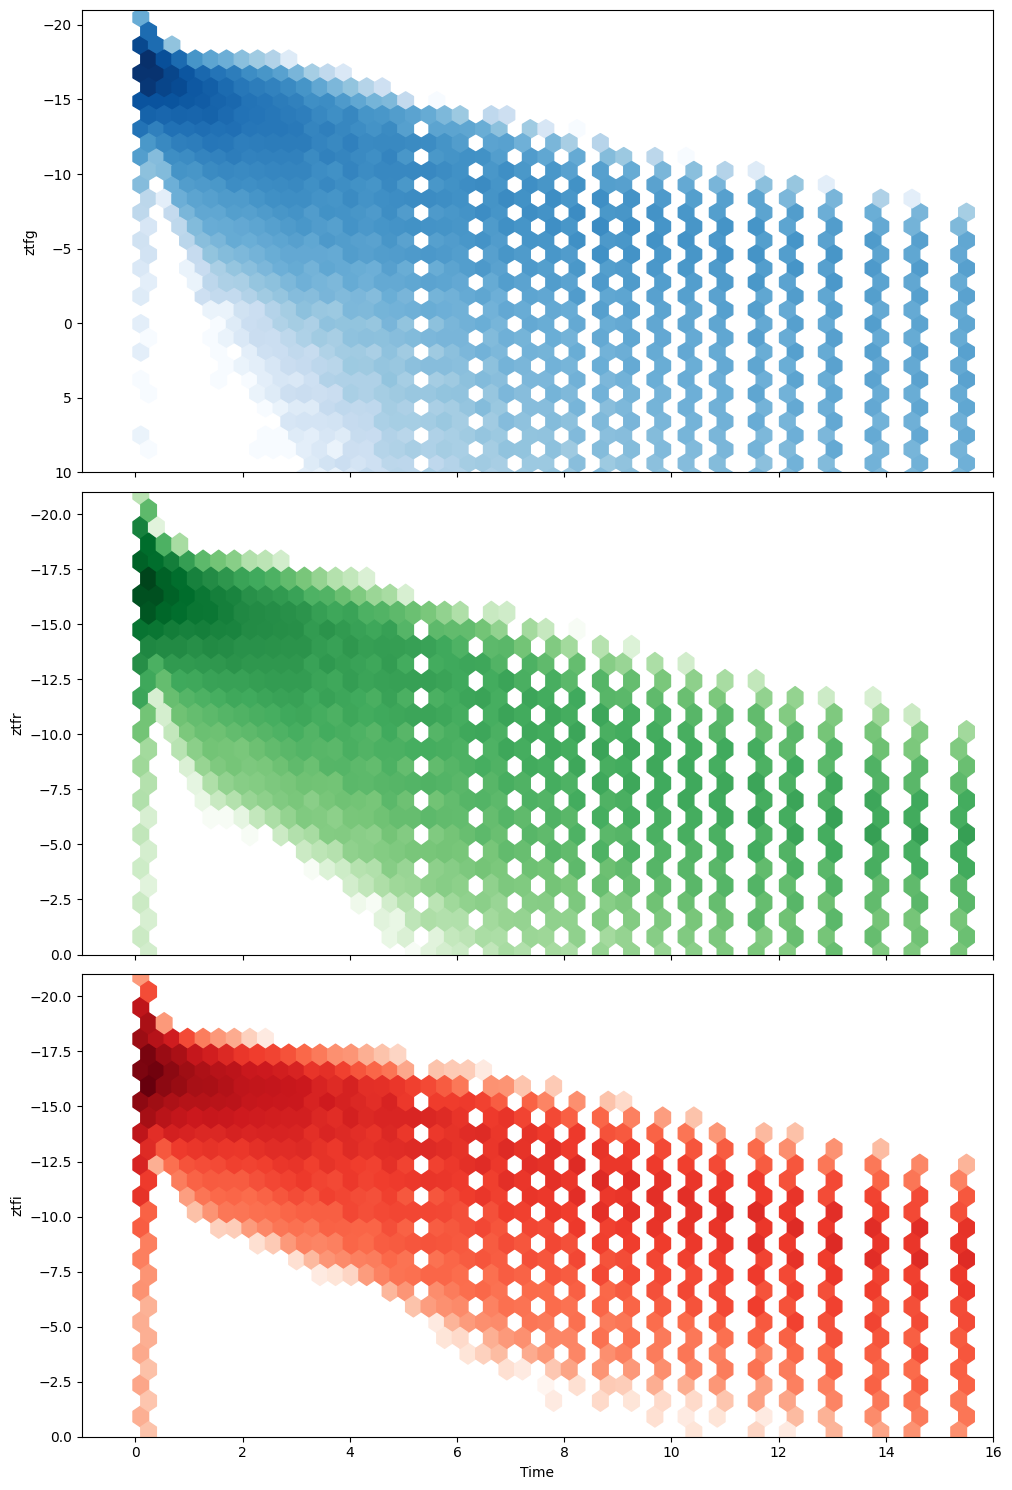

In [4]:
data_t = []
data_ztfg = []
data_ztfr = []
data_ztfi = []

for key, value in bulla_grid_lightcurves.items():
    data_t.extend(value["t"])
    data_ztfg.extend(value["ztfg"])
    data_ztfr.extend(value["ztfr"])
    data_ztfi.extend(value["ztfi"])

fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax[0].hexbin(data_t, data_ztfg, gridsize=100, cmap='Blues', mincnt=1, bins='log')
ax[1].hexbin(data_t, data_ztfr, gridsize=100, cmap='Greens', mincnt=1, bins='log')
ax[2].hexbin(data_t, data_ztfi, gridsize=100, cmap='Reds', mincnt=1, bins='log')


ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_ylabel("ztfg")
ax[1].set_ylabel("ztfr")
ax[2].set_ylabel("ztfi")
ax[2].set_xlabel("Time")
plt.tight_layout()
[ax[i].set_xlim(-1,16) for i in range(3)];
ax[0].set_ylim(10,-21), ax[1].set_ylim(0,-21), ax[2].set_ylim(0,-21);

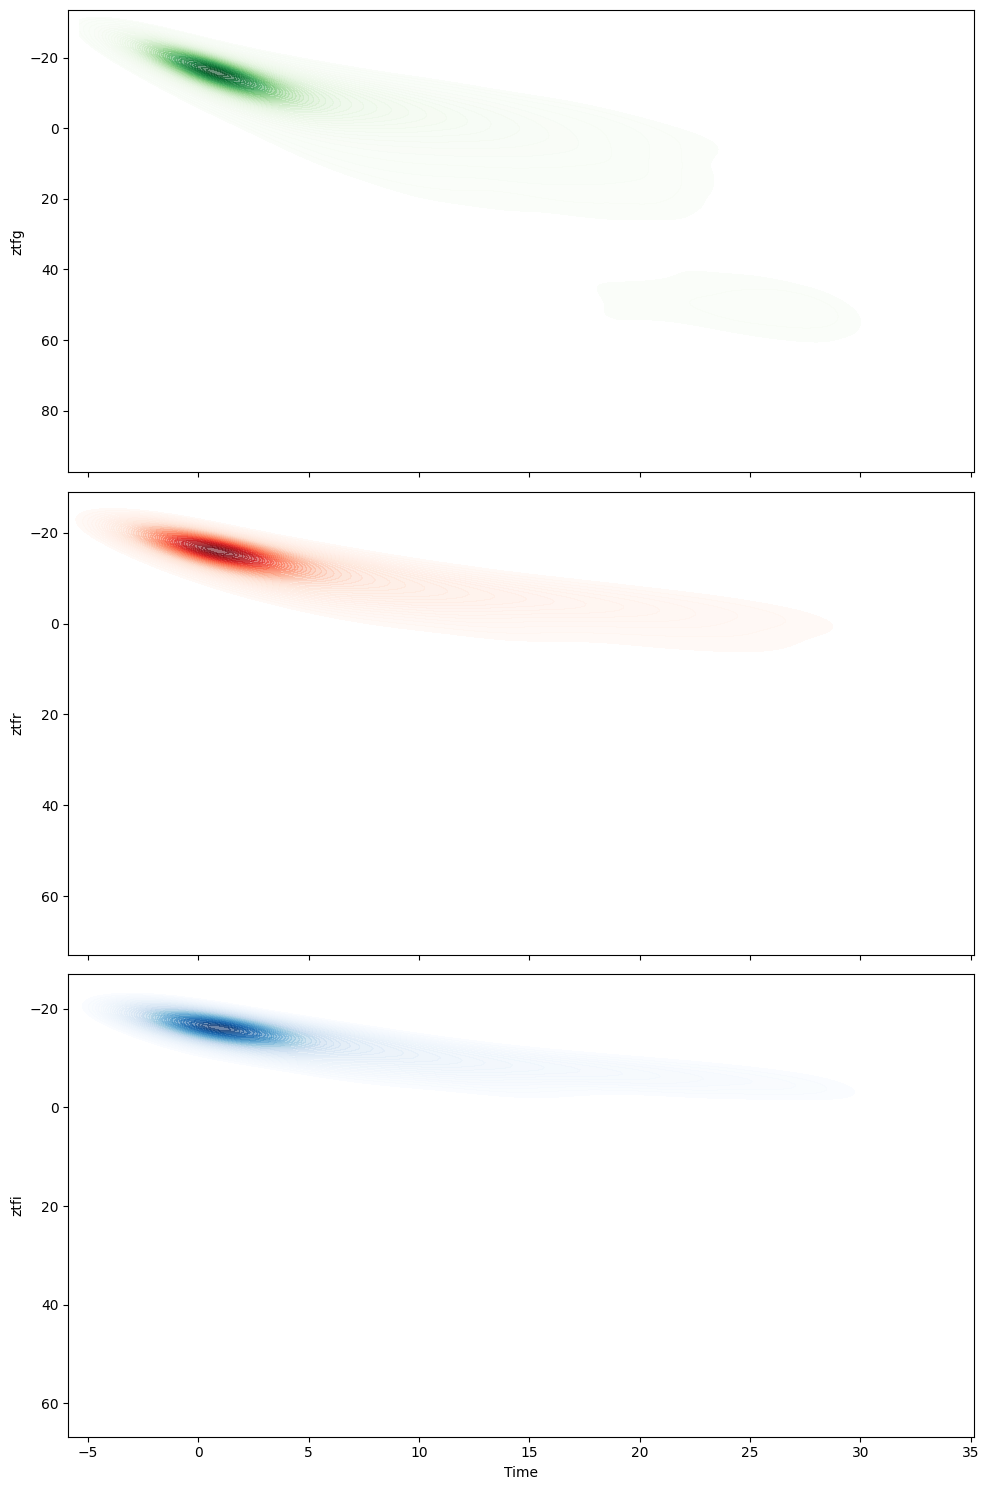

In [5]:
def subsample_data(x, y, frac=0.1, seed=42):
    np.random.seed(seed)
    indices = np.random.choice(len(x), size=int(len(x) * frac), replace=False)
    return np.array(x)[indices], np.array(y)[indices]


subsample_frac = 0.1 
sub_t, sub_ztfg = subsample_data(data_t, data_ztfg, subsample_frac)
sub_t, sub_ztfr = subsample_data(data_t, data_ztfr, subsample_frac)
sub_t, sub_ztfi = subsample_data(data_t, data_ztfi, subsample_frac)


fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
sns.kdeplot(x=sub_t, y=sub_ztfg, fill=True, ax=ax[0], cmap="Greens", alpha=0.6, levels=50, bw_adjust=2)
sns.kdeplot(x=sub_t, y=sub_ztfr, fill=True, ax=ax[1], cmap="Reds", alpha=0.6, levels=50, bw_adjust=2)
sns.kdeplot(x=sub_t, y=sub_ztfi, fill=True, ax=ax[2], cmap="Blues", alpha=0.6, levels=50, bw_adjust=2)


ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_ylabel("ztfg")
ax[1].set_ylabel("ztfr")
ax[2].set_ylabel("ztfi")
ax[2].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [6]:
## define function that, for a given lightcurve, returns the time of peak luminosity in a specified filter as well as the peak luminosity value
def get_peak(lightcurve,filter):
    '''
    Function to return the time of peak brightness and the peak brightness value for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to find the peak brightness
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time = lightcurve[lightcurve[filter] == lightcurve[filter].min()]["t"].values[0]
    max_luminosity_value = lightcurve[filter].min()
    
    return max_luminosity_time, max_luminosity_value
    

In [7]:
## given a time value for the maximum luminosity, calculate the rise rate as the difference between the peak value and the preceeding values before the max luminosity time. 
def calc_rise(lightcurve, filter):
    '''
    Function to calculate the rise time for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to calculate the rise time
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time, max_luminosity_value = get_peak(lightcurve, filter)
    rise_values = lightcurve[lightcurve["t"] < max_luminosity_time][filter]
    rise = max_luminosity_value - rise_values.max() ## more robust method would be to do a linear fit to the rise values and calculate the slope
    ## calculate time between first data point and max luminosity time
    rise_time = max_luminosity_time - lightcurve["t"].min()
    rise_rate = rise / rise_time
    
    return rise_rate

In [8]:

## define function to calculate the fade rate of lightcurve in a given filter. Take an argument for the number of days after the peak to consider when calculating the fade rate.
def calc_fade(lightcurve, filter, cutoff=5):
    '''
    Function to calculate the fade rate for a given lightcurve and filter.
    
    Args:
    lightcurve (pd.DataFrame): Lightcurve data
    filter (str): Filter for which to calculate the fade rate
    cutoff (int): Number of days after the peak to consider when calculating the fade rate
    '''
    assert filter in lightcurve.columns, f"Filter {filter} not found in lightcurve data."
    
    max_luminosity_time, max_luminosity_value = get_peak(lightcurve, filter)
    fade_values = lightcurve[lightcurve["t"] > max_luminosity_time][filter] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff][filter]
    fade_values_times = lightcurve[lightcurve["t"] > max_luminosity_time]["t"] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff]["t"]
    fade = fade_values.min() - max_luminosity_value
    fade_time = fade_values_times.max() - max_luminosity_time
    fade_rate = fade / fade_time
    
    return fade_rate

In [9]:
fade_cutoff = 2
ztfg_max_luminosity_time, ztfg_max_luminosity_value = [], []
ztfr_max_luminosity_time, ztfr_max_luminosity_value = [], []
ztfi_max_luminosity_time, ztfi_max_luminosity_value = [], []

ztfg_rise_rate, ztfr_rise_rate, ztfi_rise_rate = [], [], []
ztfg_fade_rate, ztfr_fade_rate, ztfi_fade_rate = [], [], []

for key, value in bulla_grid_lightcurves.items():
    ztfg_max_luminosity_time.append(get_peak(value, "ztfg")[0])
    ztfg_max_luminosity_value.append(get_peak(value, "ztfg")[1])
    ztfr_max_luminosity_time.append(get_peak(value, "ztfr")[0])
    ztfr_max_luminosity_value.append(get_peak(value, "ztfr")[1])
    ztfi_max_luminosity_time.append(get_peak(value, "ztfi")[0])
    ztfi_max_luminosity_value.append(get_peak(value, "ztfi")[1])
    
    ztfg_rise_rate.append(calc_rise(value, "ztfg"))
    ztfr_rise_rate.append(calc_rise(value, "ztfr"))
    ztfi_rise_rate.append(calc_rise(value, "ztfi"))
    
    ztfg_fade_rate.append(calc_fade(value, "ztfg", fade_cutoff))
    ztfr_fade_rate.append(calc_fade(value, "ztfr", fade_cutoff))
    ztfi_fade_rate.append(calc_fade(value, "ztfi", fade_cutoff))

/tmp/ipykernel_155680/2336716890.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fade_values = lightcurve[lightcurve["t"] > max_luminosity_time][filter] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff][filter]
/tmp/ipykernel_155680/2336716890.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fade_values_times = lightcurve[lightcurve["t"] > max_luminosity_time]["t"] if cutoff is None else lightcurve[lightcurve["t"] > max_luminosity_time][lightcurve["t"] < max_luminosity_time + cutoff]["t"]


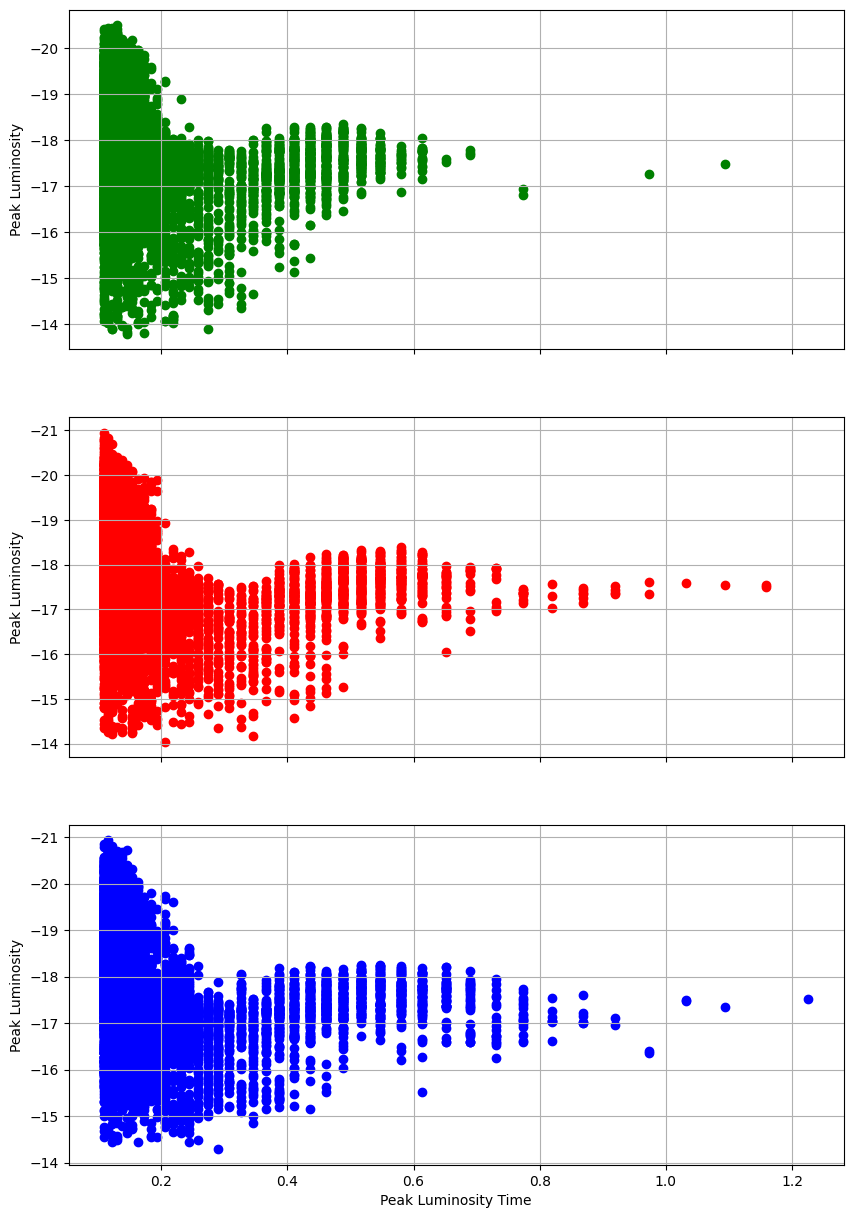

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].scatter(ztfg_max_luminosity_time, ztfg_max_luminosity_value, color='g')
ax[1].scatter(ztfr_max_luminosity_time, ztfr_max_luminosity_value, color='r')
ax[2].scatter(ztfi_max_luminosity_time, ztfi_max_luminosity_value, color='b')

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_ylabel("Peak Luminosity"), ax[1].set_ylabel("Peak Luminosity"), ax[2].set_ylabel("Peak Luminosity")
ax[2].set_xlabel("Peak Luminosity Time");

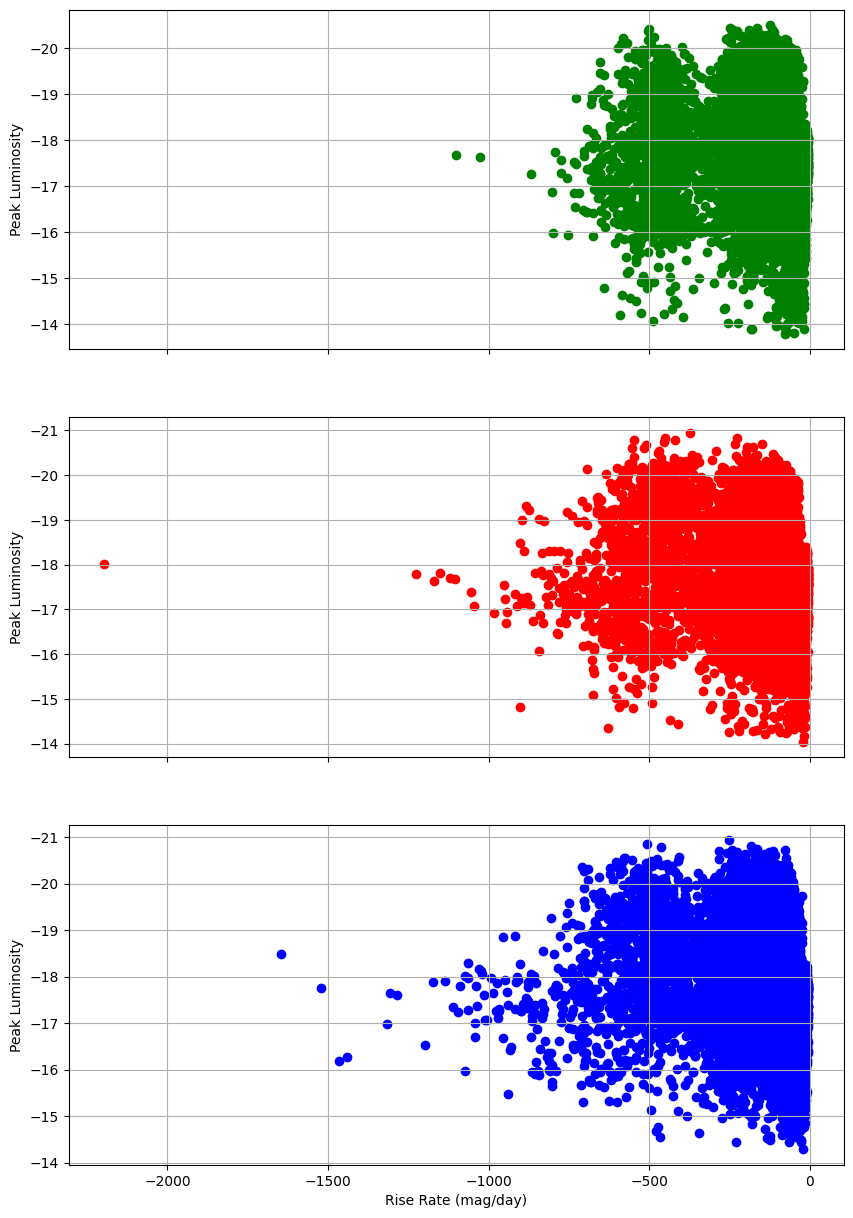

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].scatter(ztfg_rise_rate, ztfg_max_luminosity_value, color='g')
ax[1].scatter(ztfr_rise_rate, ztfr_max_luminosity_value, color='r')
ax[2].scatter(ztfi_rise_rate, ztfi_max_luminosity_value, color='b')


ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_ylabel("Peak Luminosity"), ax[1].set_ylabel("Peak Luminosity"), ax[2].set_ylabel("Peak Luminosity")
ax[2].set_xlabel("Rise Rate (mag/day)");
# ax[0].set_xscale("symlog"), ax[1].set_xscale("symlog"), ax[2].set_xscale("symlog")

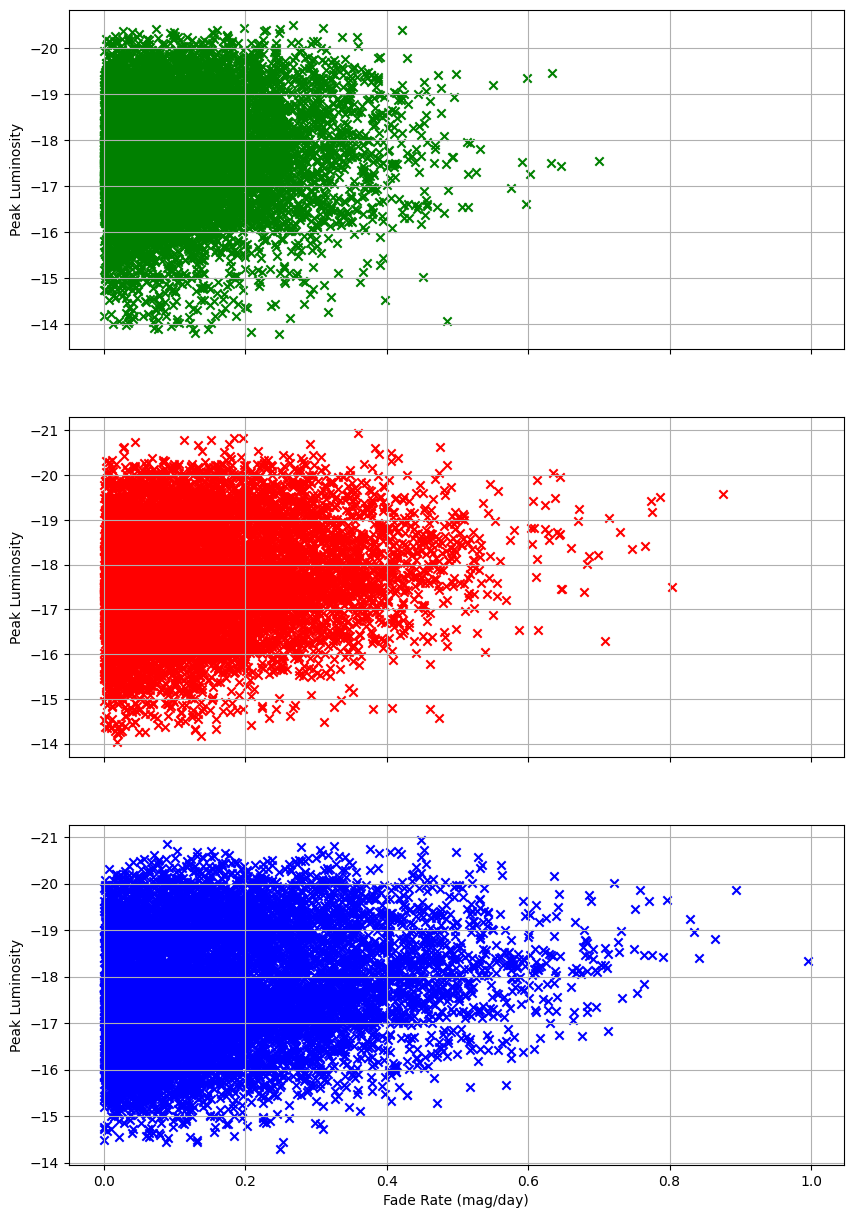

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].scatter(ztfg_fade_rate, ztfg_max_luminosity_value, color='g', marker='x')
ax[1].scatter(ztfr_fade_rate, ztfr_max_luminosity_value, color='r', marker='x')
ax[2].scatter(ztfi_fade_rate, ztfi_max_luminosity_value, color='b', marker='x')

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis()
ax[0].set_ylabel("Peak Luminosity"), ax[1].set_ylabel("Peak Luminosity"), ax[2].set_ylabel("Peak Luminosity")
ax[2].set_xlabel("Fade Rate (mag/day)");


(Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'ztfg - ztfr'),
 Text(0, 0.5, 'ztfg - ztfi'))

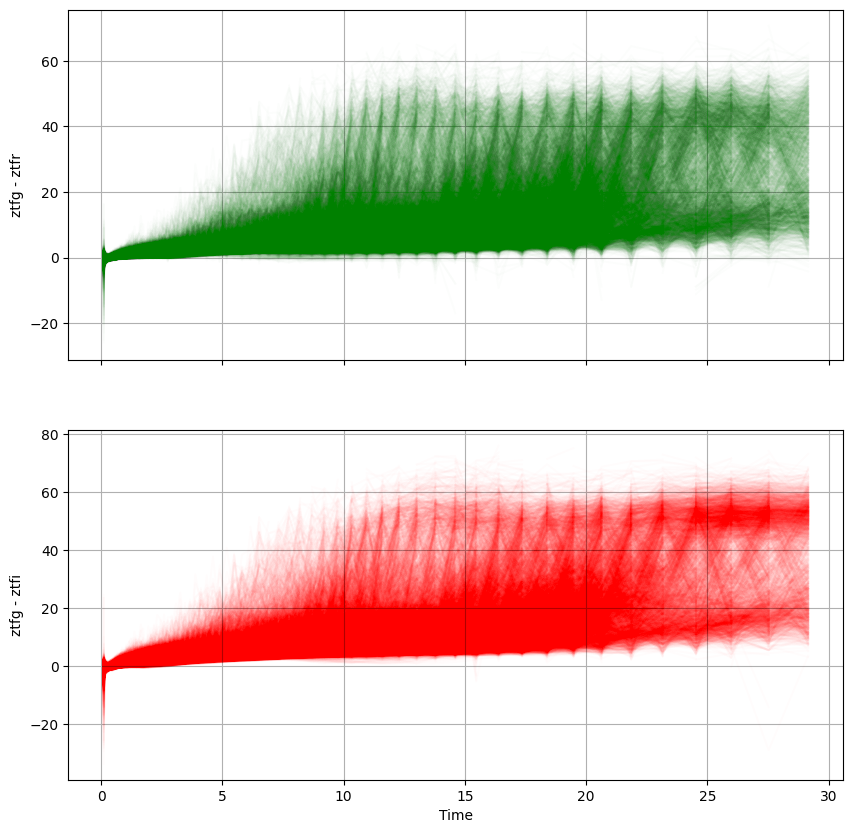

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].grid(), ax[1].grid()
[ax[0].plot(value["t"], value["ztfg"]-value["ztfr"], alpha=0.01, color='g') for key, value in bulla_grid_lightcurves.items()]
[ax[1].plot(value["t"], value["ztfg"]-value["ztfi"], alpha=0.01, color='r') for key, value in bulla_grid_lightcurves.items()]
ax[1].set_xlabel("Time"), ax[0].set_ylabel("ztfg - ztfr"), ax[1].set_ylabel("ztfg - ztfi")

In [14]:
hist_data = {}
for filter in ["ztfg", "ztfr", "ztfi"]:
    temp_combined_lightcurve_data = np.concatenate(
        [bulla_grid_lightcurves[filename][filter] for filename in bulla_grid_files]
    )
    temp_combined_timeseries_data = np.concatenate(
        [bulla_grid_lightcurves[filename]["t"] for filename in bulla_grid_files]
    )
    # Exclude NaN values from the data
    valid_indices = np.isfinite(temp_combined_lightcurve_data) & np.isfinite(temp_combined_timeseries_data)
    temp_combined_lightcurve_data = temp_combined_lightcurve_data[valid_indices]
    temp_combined_timeseries_data = temp_combined_timeseries_data[valid_indices]
    hist_data[filter] = np.histogram2d(
        temp_combined_timeseries_data, temp_combined_lightcurve_data, bins=100
    )


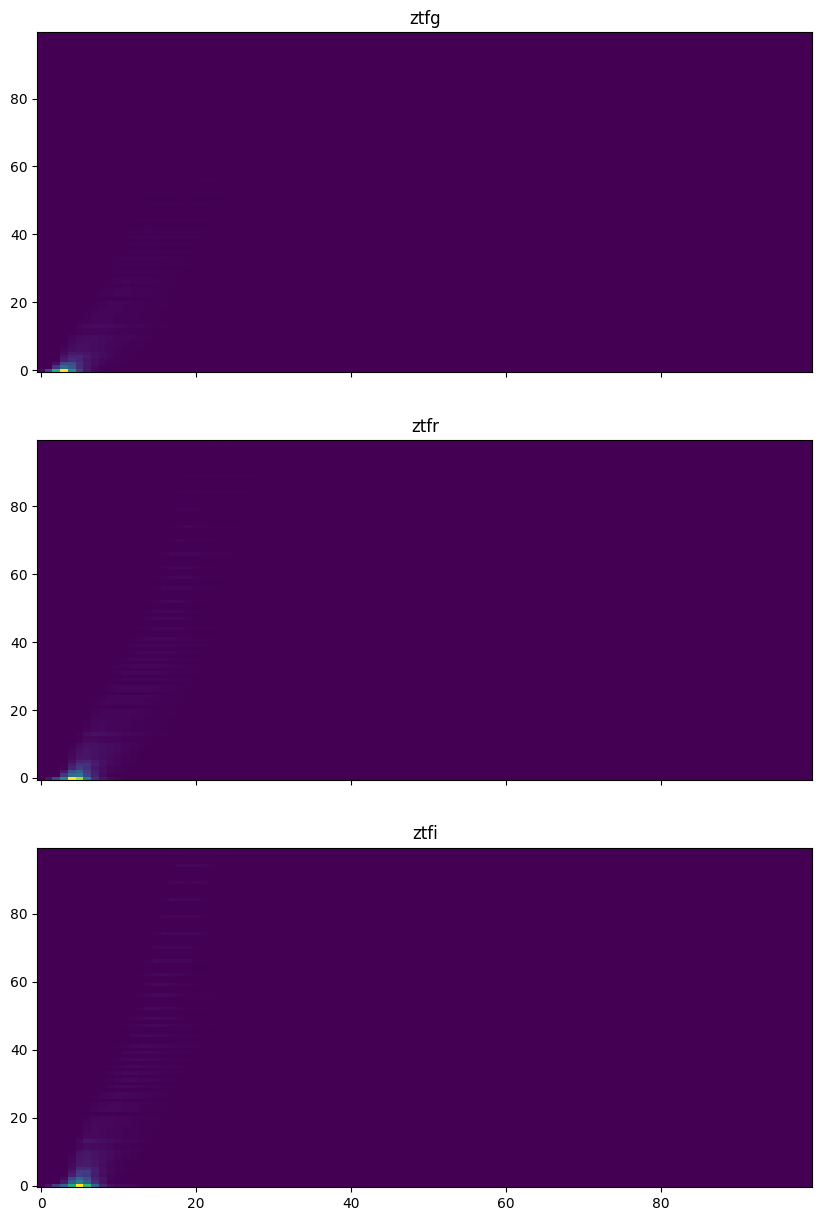

In [15]:
## plot hist data
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
for i, filter in enumerate(["ztfg", "ztfr", "ztfi"]):
    ax[i].imshow(hist_data[filter][0], aspect="auto", origin="lower", cmap="viridis")
    ax[i].set_title(filter)

following code is broken for some reason

the fwhm function should also be updated to use the dictionary structure as above, no reason to read in every file again

In [16]:
def fwhm(lightcurve, filter):
    '''
    Function to calculate the duration the lightcurve is brighter than the half maximum value. Here, lightcurves are in magnitudes, so the "maximum" is the most negative value. less negative values are dimmer than more negative values.
    
    Args:
    - lightcurve (string): path to lightcurve. Read in by read_lightcurve_file (NMMA Note: using pandas here, will have to later adapt to using the dict as is standard for the NMMA version of function)
    - filter (string, list): filter(s) to calculate FWHM for. If multiple filters are provided in a list, the function will return each filter's FWHM as a dictionary.
    
    Returns:
    - FWHM (float, dict): dictionary where each key corresponds to a filter and each value is a tuple containing the maximum magnitude in the first index and the duration it is brighter than half maximum in the second index.
    
    TODO: make more resilient to positive magnitudes, switch to using dict as input
    '''
    
    ## read in lightcurve
    lc = read_lightcurve_file(lightcurve)
    
    ## if filter is a string, convert to list
    if isinstance(filter, str):
        filter = [filter]
    
    ## ensure all filters are in the lightcurve 
    for f in filter:
        if f not in lc.columns:
            raise ValueError(f"Filter {f} not in lightcurve. Available filters are {lc.columns.pop('t')}")
    
    ## calculate the maximum magnitude for each filter and then calculate the duration it is brighter than half the maximum
    FWHM = {}
    for f in filter:
        max_mag = lc[f].min()
        bright = lc[lc[f] < max_mag/2]
        duration = bright["t"].max() - bright["t"].min()
        FWHM[f] = (max_mag, duration)
    return FWHM


In [17]:
# fwhm(bulla_grid_files[0], "ztfg")

In [18]:


# # Initialize an empty list to store the results
# df_list = []
# filters = ['ztfg', 'ztfr', 'ztfi']
# # Loop through the files
# for f in bulla_grid_files:
#     # Loop through the filters
#     for filt in filters:
#         # Calculate the FWHM
#         fwhm_value = fwhm(f, filt)
#         # Create a temporary DataFrame and append it to the list
#         df_temp = pd.DataFrame({'file': [f], 'filter': [filt], 'peak_magnitude': [fwhm_value[filt][0]], 'fwhm': [fwhm_value[filt][1]]})
#         df_list.append(df_temp)

# # Concatenate all the dataframes in the list
# df_fwhm = pd.concat(df_list, ignore_index=True)

In [19]:
# # Create a 3 subplot figure
# fig, axs = plt.subplots(3, 1, figsize=(10, 15))
# colors = ['green', 'red', 'violet']
# # Loop through the filters and plot the data
# for i, filter in enumerate(['ztfg', 'ztfr', 'ztfi']):
#     axs[i].grid()
#     df_filter = df_fwhm[df_fwhm['filter'] == filter]
#     sns.scatterplot(data=df_filter, x='fwhm', y='peak_magnitude', ax=axs[i], color=colors[i]).set_title(f'Filter: {filter}')
#     axs[i].invert_yaxis()
#     axs[i].set_xlabel('Time Above Half Maximum (days)') if i == 2 else axs[i].set_xlabel('')
#     axs[i].set_ylabel('Peak Magnitude')
    

# plt.suptitle(f'Bu2022Ye Grid Lightcurves (n={len(bulla_grid_files)})')
# plt.tight_layout()
# plt.show()